# Onside Kick Research

## 1. Load the data 

In [1]:
import json
import re
from os.path import join
import os
import unicodedata

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
import shap
from scipy.stats import gaussian_kde
import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [6]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)

        tmp["start_time_minutes"] = tmp["start_time"].apply(lambda x: x["minutes"])
        tmp["start_time_seconds"] = tmp["start_time"].apply(lambda x: x["seconds"])
        tmp["end_time_minutes"] = tmp["end_time"].apply(lambda x: x["minutes"])
        tmp["end_time_seconds"] = tmp["end_time"].apply(lambda x: x["seconds"])
        tmp.drop(columns=["start_time","end_time"], inplace=True)

        season_drives = tmp.copy()
                
        season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(season_drives)
    
drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [7]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [8]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [9]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Predict Kickoff Decision: Onside or Regular

In [53]:
def remove_accents(text):
    if not isinstance(text, str):
        return text
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

kickoff_plays_types = ["Kickoff", "Kickoff Return (Offense)", "Kickoff Return Touchdown"]

kickoff_plays = (
    plays
    .query('play_text.notnull()')
    .query('~play_text.str.lower().str.contains("field goal")')
    .query('play_type in @kickoff_plays_types or play_text.str.lower().str.contains("on-side")')
    .assign(
        kickoff_yards= lambda x: np.where(
            x.play_text.str.extract(r'kickoff for (\d+) yds')[0].notnull(),
            x.play_text.str.extract(r'kickoff for (\d+) yds')[0],
            x.play_text.str.extract(r'kickoff for (\d+) yards')[0]
        ).astype(float),
    )
    .assign(
        onside_kick=lambda x: (
            x['play_text'].str.lower().str.contains('on-side') |
            (x.kickoff_yards <= 15)  # Assuming onside kicks are <= 15 yards
        )
    )
    .assign(
        recovery_team=lambda x: np.where(
            x.onside_kick,
            np.where(x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0].notnull(),
                x.play_text.str.extract(r'on-side kick recovered by (.*?) at the')[0],
                x.play_text.str.extract(r'on-side kick, recovered by (.*?) on')[0]
            ),
            np.nan
        ),
        offense_normalized=lambda x: x['offense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True),
        defense_normalized=lambda x: x['defense'].str.lower().apply(remove_accents)
            .str.replace(r'ualbany', 'albany', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'^st \b', 'state ', regex=True)
            .str.replace(r'\b\'\b', '', regex=True)
            .str.replace(r'[()]', '', regex=True)
    )
    .assign(
        recovery_team=lambda x: x.recovery_team.str.lower().apply(remove_accents)
            .str.replace(r'[()]', '', regex=True)
            .str.replace(r'\b st \b', ' state', regex=True)
            .str.replace(r'\b st$', ' state', regex=True)
            .str.replace(r'\b eastrn \b', ' eastern ', regex=True)
            .str.replace(r'^eastrn \b', 'eastern ', regex=True)
            .str.replace(r'\b eastrn$', ' eastern', regex=True)
            .str.replace(r'\b westrn \b', ' western ', regex=True)
            .str.replace(r'^westrn \b', 'western ', regex=True)
            .str.replace(r'\b westrn$', ' western', regex=True)
            .str.replace(r'\b southrn \b', ' southern ', regex=True)
            .str.replace(r'^southrn \b', 'southern ', regex=True)
            .str.replace(r'\b southrn$', ' southern', regex=True)
            .str.replace(r'\b northrn \b', ' northern ', regex=True)
            .str.replace(r'^northrn \b', 'northern ', regex=True)
            .str.replace(r'\b northrn$', ' northern', regex=True)
            .str.replace(r'\b north \b', ' northern ', regex=True)
            .str.replace(r'ul lafayette', 'louisiana', regex=True)
            .str.replace(r'^ga \b', 'georgia ', regex=True)
            .str.replace(r'\b fl$', '', regex=True)
            .str.replace(r'olddominion', 'old dominion', regex=False)
            .str.replace(r'texassan', 'utsa', regex=False)
            .str.replace(r'\b tenn$', ' tennessee', regex=True)
            .str.replace(r'jmu', 'james madison', regex=False)
            .str.replace(r'appalachian state', 'app state', regex=False)
            .str.replace(r'northernil', 'northern illinois', regex=False)
            .str.replace(r'connecticut', 'uconn', regex=False)
            .str.replace(r'\b intl$', ' international', regex=True)
            .str.replace(r'^abil \b', 'abilene ', regex=True)
            .str.replace(r'eku', 'eastern kentucky', regex=False)
            .str.replace(r'^fla \b', 'florida ', regex=True)
            .str.replace(r'\b mich$', ' michigan', regex=True)
            .str.replace(r'ut san antonio', 'utsa', regex=False)
            .str.replace(r'niu team', 'northern illinois', regex=False)
            .str.replace(r'nc a&t', 'north carolina a&t', regex=False)
            .str.replace(r'coastl carolina', 'coastal carolina', regex=False)
            .str.replace(r'cmu team', 'central michigan', regex=False)
            .str.replace(r'tenn martin', 'ut martin', regex=False)
            .str.replace(r'sam houston state', 'sam houston', regex=False)
            .str.replace(r'^gs \b', 'georgia southern ', regex=True)
            .str.replace(r'^cal davis\b', 'california davis', regex=True)
            .str.replace(r'^asu \b', 'arkansas state ', regex=True)
            .str.replace(r'^nc ratliff\b', 'north carolina', regex=True)
            .str.replace(r'^umass \b', 'massachusetts ', regex=True)
            .str.replace(r'north cent col', 'north central college', regex=False)
            .str.replace(r'^valpo \b', 'valparaiso ', regex=True)
            .str.replace(r'^utm \b', 'ut martin ', regex=True)
            .str.replace(r'sfa', 'stephen f. austin', regex=False)
            .str.replace(r'gasouthern', 'georgia southern', regex=False)
            .str.replace(r'incarnatew', 'incarnate word', regex=False)
            .str.replace(r'nc central', 'north carolina central', regex=False)
            .str.replace(r'^ks \b', 'kansas state ', regex=True)
            .str.replace(r'^tln \b', 'tulane ', regex=True)
            .str.replace(r'central ark', 'central arkansas', regex=False)
            .str.replace(r'^miz \b', 'missouri ', regex=True)
            .str.replace(r'arizonast', 'arizona state', regex=False)
            .str.strip()
    )
    .assign(
        recovered_by=lambda x: np.where(
            x.onside_kick & x.recovery_team.notnull(),
            np.where(
                x.recovery_team == x.offense_normalized,
                'offense',
                np.where(
                    x.recovery_team == x.defense_normalized,
                    'defense',
                    np.where(
                        [rt.startswith(on) if pd.notnull(rt) and pd.notnull(on) else False
                        for rt, on in zip(x.recovery_team, x.offense_normalized)],
                        'offense',
                        np.where(
                            [rt.startswith(dn) if pd.notnull(rt) and pd.notnull(dn) else False
                            for rt, dn in zip(x.recovery_team, x.defense_normalized)],
                            'defense',
                            'unknown'
                        )
                    )
                )
            ),
            np.where(
                x.onside_kick,
                np.where(
                    x.play_text.str.lower().str.contains(' return ', regex=False),
                    'defense',
                    'unknown'
                ),
                None
            )
        )
    )
    .query('recovered_by != "unknown"')
    .drop(columns=['recovery_team', 'offense_normalized', 'defense_normalized'])
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        need_onside_kick = lambda x: np.where(
            # Losing with =< 60 seconds
            ((x.score_diff < 0) & (x.seconds_remaining <= 60)) |
            # Losing with <= 2 min and <= 1 timeout
            ((x.score_diff < 0) & (x.seconds_remaining <= 120) & (x.offense_timeouts <= 1)) |
            # Losing by 2+ possessions with <= 3 min
            ((x.score_diff < -8) & (x.seconds_remaining <= 180)) |
            # Down 3+ scores (17+) with < 5 min
            ((x.score_diff <= -17) & (x.seconds_remaining < 300)),
            True, False
        ),
        losing_by_a_score_under_one_minute= lambda x: np.where(
            (x.seconds_remaining < 60) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 2),
            True, False
        ),
        losing_by_a_score_under_two_minutes = lambda x: np.where(
            (x.seconds_remaining < 120) & (-8 <= x.score_diff) & (x.score_diff < 0) & (x.offense_timeouts <= 1),
            True, False
        ),
        losing_by_two_scores_under_three_minutes = lambda x: np.where(
            (x.seconds_remaining < 180) & (-17 <= x.score_diff) & (x.score_diff < -8),
            True, False
        ),
        losing_by_three_scores_under_five_minutes = lambda x: np.where(
            (x.seconds_remaining < 300) & (x.score_diff <= -17),
            True, False
        )
    )
)

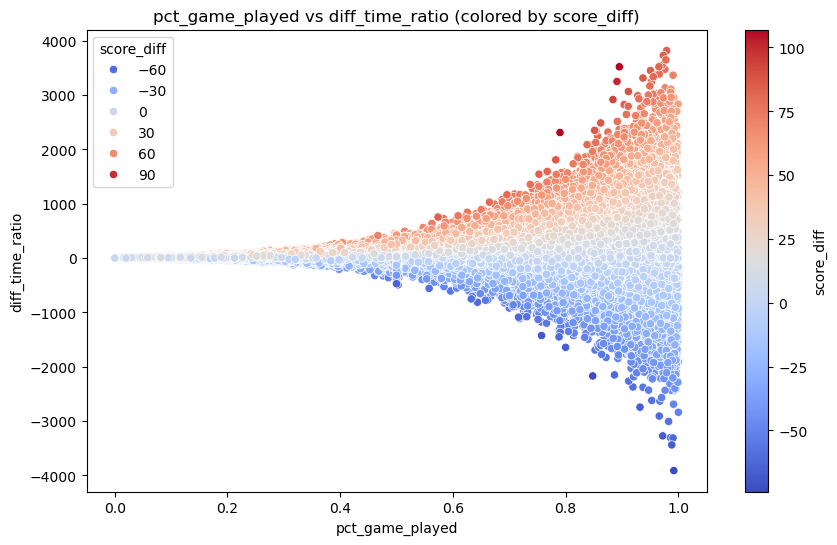

In [54]:
import matplotlib as mpl

x, y = 'pct_game_played', 'diff_time_ratio'
hue = 'score_diff'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=kickoff_plays.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=kickoff_plays[hue].min(), vmax=kickoff_plays[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

In [55]:
kickoff_plays.onside_kick.value_counts(normalize=True)

onside_kick
False    0.985262
True     0.014738
Name: proportion, dtype: float64

In [56]:
features = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

data = kickoff_plays[features + ['onside_kick']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['onside_kick']
)
test_x, test_y = test_data[features], test_data['onside_kick']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['onside_kick'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['onside_kick']
)

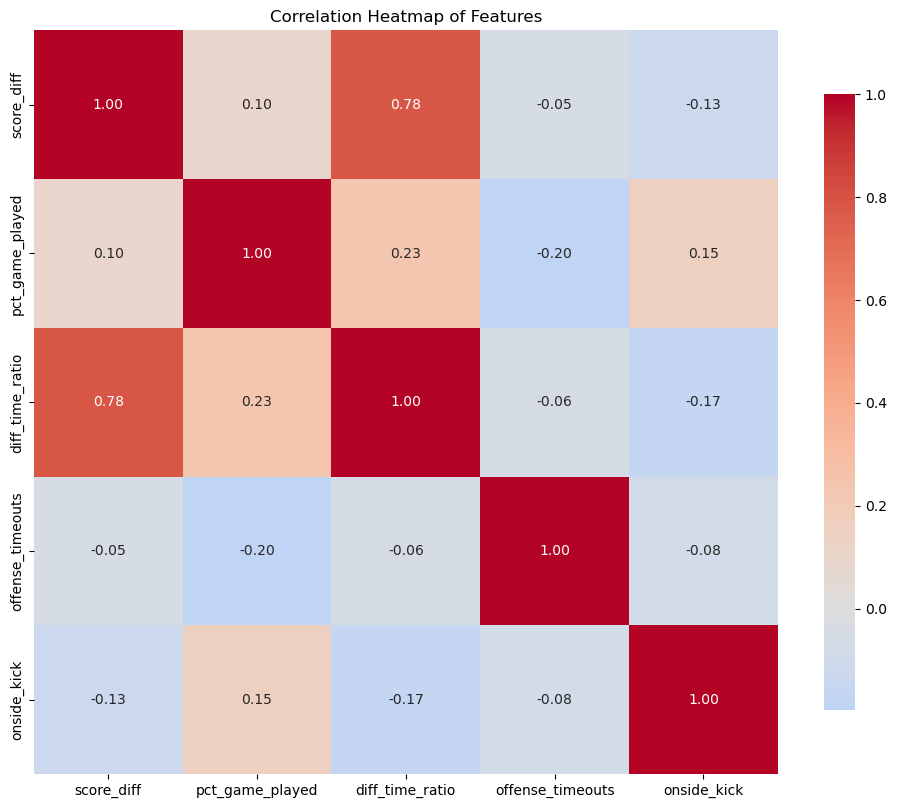

In [57]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [58]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff', 
    'pct_game_played',
    'diff_time_ratio',
    'offense_timeouts',
]

monotonic_constraints_map = {
    "offense_timeouts": -1
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="onside_kick_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

Number of boosted rounds: 137
Final train log loss: 0.039
Final train PR AUC: 0.563
Final validation log loss: 0.041
Final validation PR AUC: 0.523
Final test log loss: 0.042
Final test PR AUC: 0.524


In [59]:
p = kickoff_plays.onside_kick.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of kickoff attempt: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of kickoff attempt: 0.985
Baseline log loss: 0.077


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_20072/2333610454.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


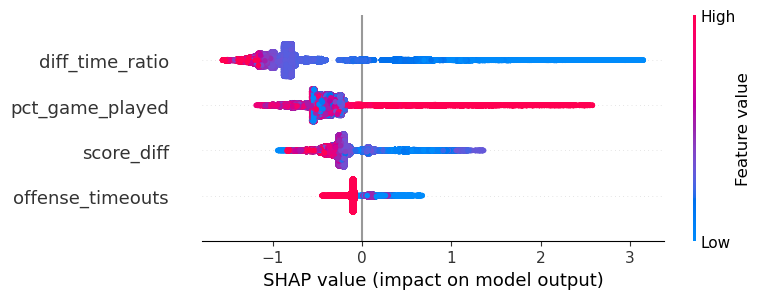

In [60]:
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

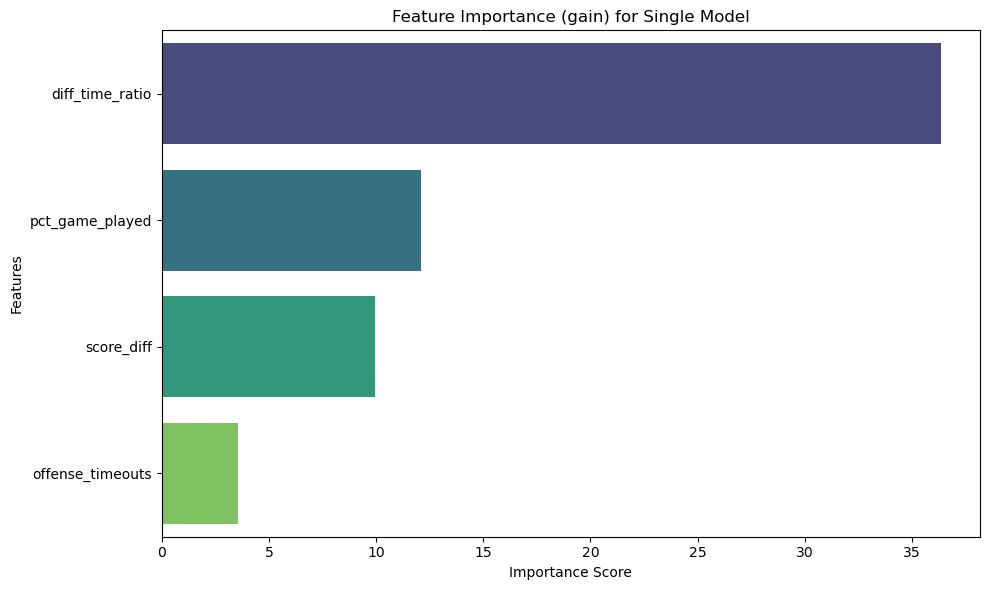

In [61]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [62]:
# predict onside_kick_proba for all plays
kickoff_plays['onside_kick_proba'] = final_model.predict(xgb.DMatrix(kickoff_plays[feature_names]))

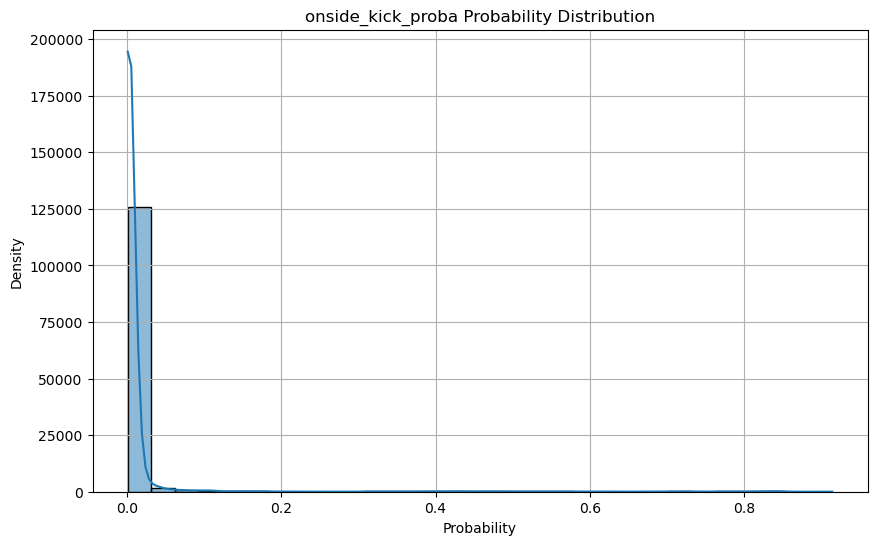

In [63]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(kickoff_plays, col='onside_kick_proba')

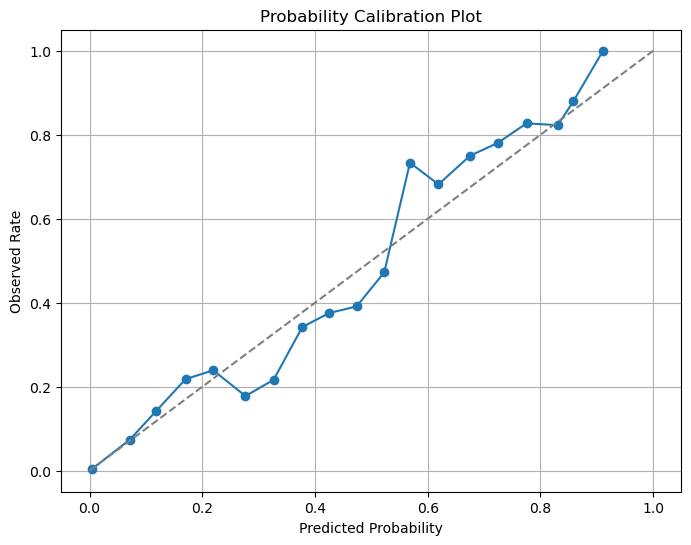

In [64]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(kickoff_plays, proba_col='onside_kick_proba', actual_col='onside_kick', bins=20)

In [65]:
kickoff_plays.sort_values(
    by='onside_kick_proba', 
    ascending=False
)[['offense','defense'] + feature_names + ['onside_kick', 'onside_kick_proba']].head(20).reset_index(drop=True)

,offense,defense,score_diff,pct_game_played,diff_time_ratio,offense_timeouts,onside_kick,onside_kick_proba
0,Kansas State,Oklahoma,-6,0.977778,-299.726556,0.0,True,0.913922
1,Auburn,Tennessee,-6,0.989722,-314.394434,0.0,True,0.913806
2,Northern Illinois,Ball State,-6,0.987778,-311.958629,0.0,True,0.913806
3,Purdue,Iowa,-6,0.993333,-318.968644,0.0,True,0.913806
4,Arizona,Texas Tech,-6,0.985000,-308.511608,0.0,True,0.913806
5,Southern Miss,Middle Tennessee,-6,0.992500,-317.907185,0.0,True,0.913806
6,North Dakota,South Dakota,-6,0.994444,-320.389437,0.0,True,0.913806
7,Virginia,Miami,-6,0.990278,-315.093866,0.0,True,0.913806
8,BYU,Massachusetts,-6,0.985278,-308.854589,0.0,True,0.913806
9,Troy,Clemson,-6,0.987778,-311.958629,0.0,True,0.913806


In [66]:
kickoff_plays.columns

Index(['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds', 'kickoff_yards', 'onside_kick',
       'recovered_by', 'score_diff', 'seconds_remaining', 'pct_game_played',
       'diff_time_ratio', 'need_onside_kick',
       'losing_by_a_score_under_one_minute',
       'losing_by_a_score_under_two_minutes',
       'losing_by_two_scores_under_three_minutes',
       'losing_by_three_scores_under_five_minutes', 'onside_kick_proba',
       'proba_bin'],
      dtype='object')

In [67]:
kickoff_plays.sort_values(
    by='onside_kick_proba', 
    ascending=False
)[['offense','defense'] + feature_names + ['onside_kick', 'onside_kick_proba']].head(20).reset_index(drop=True)

,offense,defense,score_diff,pct_game_played,diff_time_ratio,offense_timeouts,onside_kick,onside_kick_proba
0,Kansas State,Oklahoma,-6,0.977778,-299.726556,0.0,True,0.913922
1,Auburn,Tennessee,-6,0.989722,-314.394434,0.0,True,0.913806
2,Northern Illinois,Ball State,-6,0.987778,-311.958629,0.0,True,0.913806
3,Purdue,Iowa,-6,0.993333,-318.968644,0.0,True,0.913806
4,Arizona,Texas Tech,-6,0.985000,-308.511608,0.0,True,0.913806
5,Southern Miss,Middle Tennessee,-6,0.992500,-317.907185,0.0,True,0.913806
6,North Dakota,South Dakota,-6,0.994444,-320.389437,0.0,True,0.913806
7,Virginia,Miami,-6,0.990278,-315.093866,0.0,True,0.913806
8,BYU,Massachusetts,-6,0.985278,-308.854589,0.0,True,0.913806
9,Troy,Clemson,-6,0.987778,-311.958629,0.0,True,0.913806


In [68]:
model_dir = join('../models/raw', 'kickoffs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"onside_decision_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/kickoffs' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_20072/1082815795.py:6: UserWarning: [00:21:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


## 3. Predict If Kicking Team Recovers Onside Kick
XGBoost Model preforms poorly -> onside kicks are two random (based on the available data) -> use base rates.

In [69]:
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'period', 'offense',
       'defense','recovered_by', 'seconds_remaining', 'clock_minutes', 'clock_seconds']

onside_kicks = (
    kickoff_plays.query('onside_kick == True')[cols].rename(
        columns={
            'id': 'play_id',
        }
    )
    .assign(
        kicking_team_recovered=lambda x: np.where(
            x['recovered_by'] == "offense", True, False
        ),
    )
    .drop(columns=['recovered_by'])
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']].rename(
            columns={'id': 'game_id'}
        ),
        on='game_id',
        how='left'
    )
    .merge(
        games[['id','season','week','venue_id']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'offense', 
            'elo': 'offense_elo',
            'division': 'offense_division'
        }),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'defense', 
            'elo': 'defense_elo',
            'division': 'defense_division'
        }),
        on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        venues[['id', 'elevation']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    ).drop(columns=['venue_id'])
)

onside_kicks['elevation'] = onside_kicks['elevation'].astype(float)

onside_kicks = (
    onside_kicks
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        wind_speed = np.where(onside_kicks.game_indoors, 0, onside_kicks.wind_speed.fillna(int(onside_kicks.wind_speed.mean()))),
        elevation = onside_kicks.elevation.fillna(int(onside_kicks.elevation.astype(float).mean())),
        precipitation = np.where(onside_kicks.game_indoors, 0, onside_kicks.precipitation.fillna(int(onside_kicks.precipitation.mean()))),
        temperature = np.where(onside_kicks.game_indoors, 70, onside_kicks.temperature.fillna(int(onside_kicks.temperature.mean()))),
    )
    .drop(columns=['game_indoors'])
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
)


onside_kicks.head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,seconds_remaining,clock_minutes,clock_seconds,kicking_team_recovered,temperature,wind_speed,precipitation,season,week,offense_division,offense_elo,defense_division,defense_elo,elevation,pct_game_played
0,333622306200,33362230618,333622306,18,7,4,Michigan,Kansas State,75,1,15,False,61.0,7.0,0.0,2013,1,fbs,2687.727457,fbs,2878.346980,360.156952,0.979167
1,332422567305,33242256727,332422567,27,8,4,SMU,Texas Tech,65,1,5,True,100.9,4.7,0.0,2013,1,fbs,1995.644402,fbs,2322.587978,169.405808,0.981944
2,332430251149,33243025115,332430251,15,6,3,New Mexico State,Texas,1800,15,0,False,98.1,7.0,0.0,2013,1,fbs,939.848251,fbs,2596.277134,160.308945,0.500000
3,332430249015,33243024901,332430249,1,3,1,Idaho,North Texas,3480,13,0,True,100.9,3.4,0.0,2013,1,fbs,1088.241488,fbs,1248.586195,198.687195,0.033333
4,340010239263,34001023932,340010239,32,20,4,Baylor,UCF,75,1,15,False,70.0,0.0,0.0,2013,1,fbs,2625.137468,fbs,2171.347997,274.000000,0.979167


In [70]:
feature_names = [
    'temperature', 
    'wind_speed', 
    'precipitation',
    'offense_elo',
    'defense_elo', 
    'elevation', 
]

data = onside_kicks[feature_names + ['kicking_team_recovered']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['kicking_team_recovered']
)
test_x, test_y = test_data[feature_names], test_data['kicking_team_recovered']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['kicking_team_recovered'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['kicking_team_recovered']
)

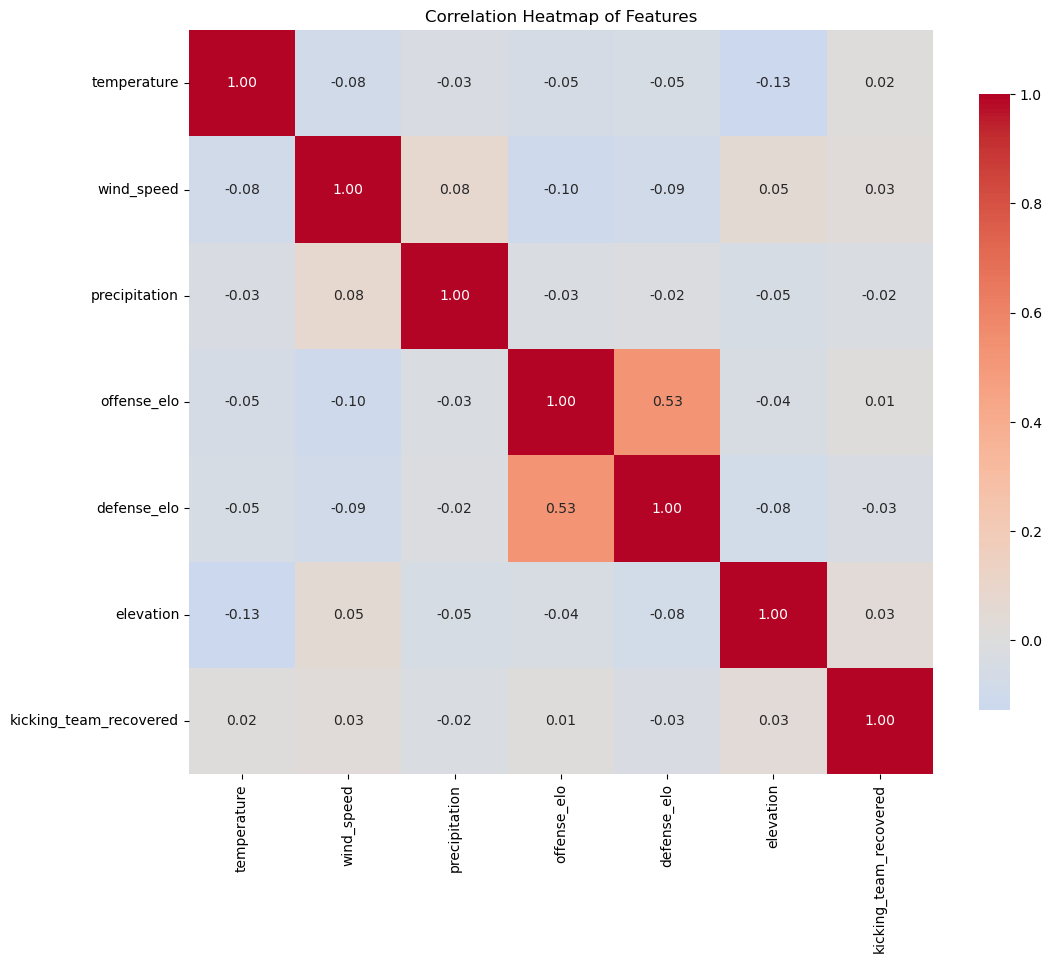

In [71]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [72]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="onside_kick_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

Number of boosted rounds: 21
Final train log loss: 0.457
Final train PR AUC: 0.460
Final validation log loss: 0.497
Final validation PR AUC: 0.235
Final test log loss: 0.504
Final test PR AUC: 0.218


In [73]:
p = onside_kicks.kicking_team_recovered.value_counts(normalize=True).values[1]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of onside kick recovery: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of onside kick recovery: 0.200
Baseline log loss: 0.500


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_20072/2333610454.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


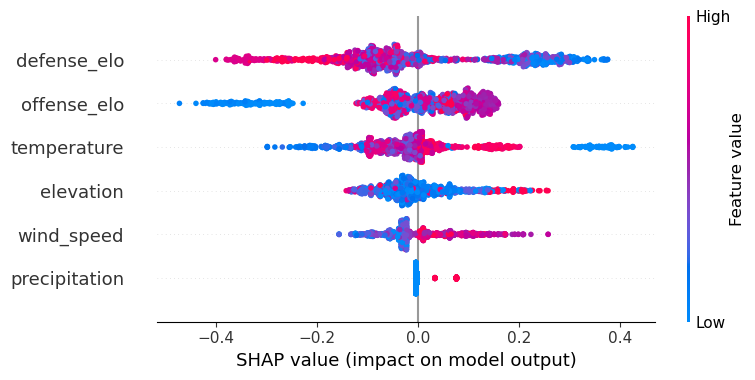

In [74]:
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

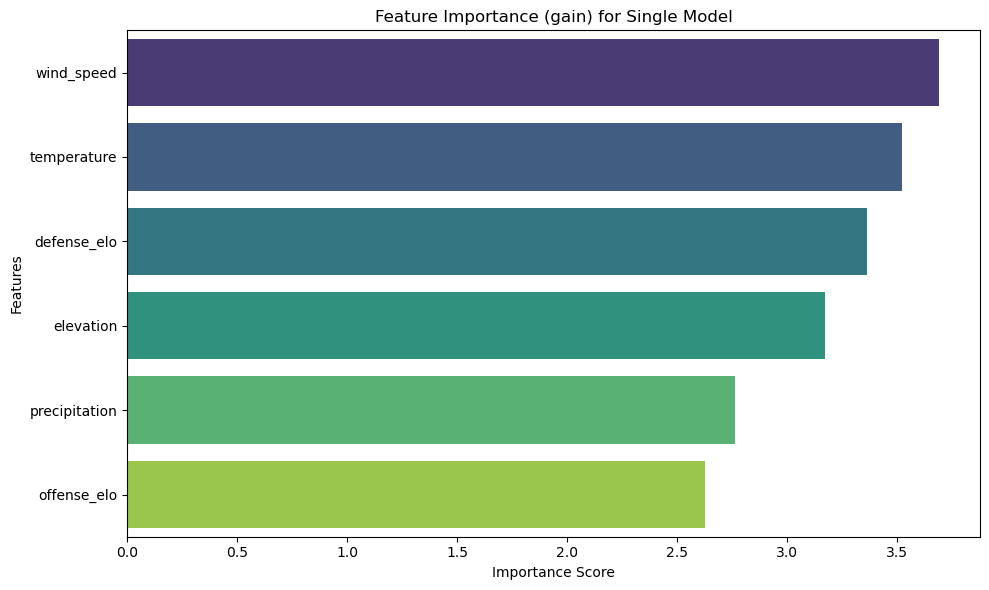

In [75]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [76]:
# predict onside_kick_proba for all plays
onside_kicks['onside_kick_recovery_proba'] = final_model.predict(xgb.DMatrix(onside_kicks[feature_names]))

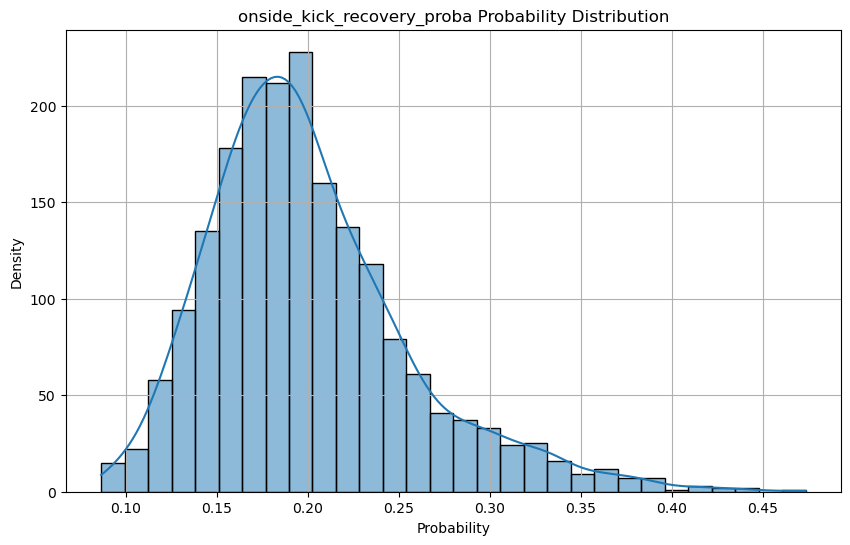

In [77]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(onside_kicks, col='onside_kick_recovery_proba')

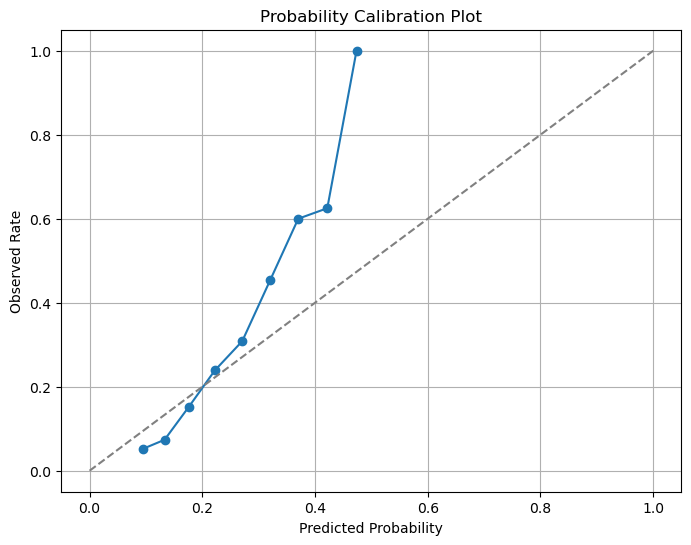

In [78]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(onside_kicks, proba_col='onside_kick_recovery_proba', actual_col='kicking_team_recovered', bins=20)

#### Using `0.247913` as the probability of recovering an onside kick, the empirical frequency from our dataset from 2013-2024.

In [79]:
onside_kicks.kicking_team_recovered.value_counts(normalize=True)

kicking_team_recovered
False    0.800207
True     0.199793
Name: proportion, dtype: float64

In [80]:
games.head()

,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


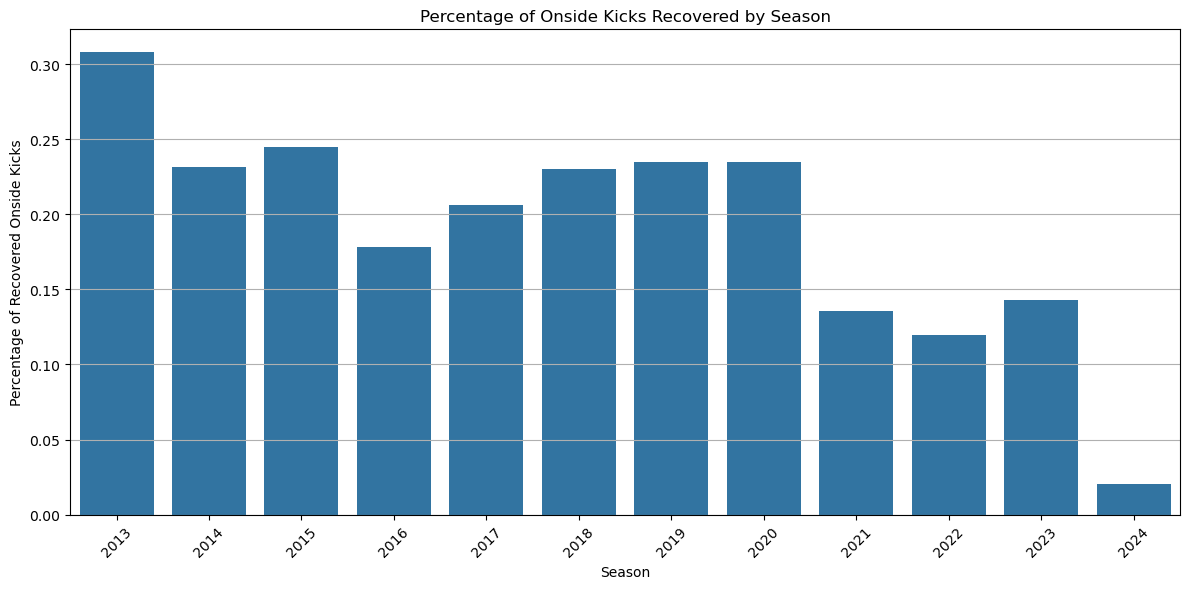

In [82]:
qry = onside_kicks.groupby('season').agg(
    total_onside_kicks=('kicking_team_recovered', 'size'),
    total_recovered=('kicking_team_recovered', 'sum'),
    pct_recovered=('kicking_team_recovered', 'mean')
).reset_index()

# plot the results
plt.figure(figsize=(12, 6))
sns.barplot(
    x='season', 
    y='pct_recovered', 
    data=qry, 
    # palette='viridis'
)
plt.title('Percentage of Onside Kicks Recovered by Season')
plt.xlabel('Season')
plt.ylabel('Percentage of Recovered Onside Kicks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 4. Predict the Yardline the Onside Kick is Recovered At
Did not attempt model to predict onside kick recovery yardline, too much randomness. Instead, opting to use the empricial distributions.

In [59]:
drives.head()

,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [65]:
plays.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [67]:
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'period', 'offense',
       'defense','recovered_by', 'seconds_remaining', 'clock_minutes', 'clock_seconds','play_text']

plays_key = (
    plays[['game_id','drive_number','play_number','clock_minutes','clock_seconds','period','id']]
    .sort_values(['game_id', 'period', 'clock_minutes', 'clock_seconds', 'drive_number', 'play_number'], ascending=[True, True, False, False, True, True])
    # plays[['game_id','drive_number','play_number','id']]
    # .sort_values(['game_id', 'drive_number', 'play_number'])
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={'index': 'row_play_id'})
    [['id', 'row_play_id']]
)

onside_kicks = (
    kickoff_plays.query('onside_kick == True')[cols].rename(
        columns={
            'id': 'play_id',
        }
    )
    .merge(
        plays_key.rename(
            columns={'id': 'play_id'}
        ),
        on='play_id',
        how='left'
    )
    .assign(
        pct_game_played = lambda x: (
            (((x['period'] - 1) * 15 * 60) +
             ((15 * 60) - (x['clock_minutes'] * 60 + x['clock_seconds']))) / (4 * 15 * 60)
        )
    )
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
    .assign(
        recovery_yardline=lambda x: (
            np.where(
                # Case 1: Standard onside recovery (e.g., "at the SMU49")
                x['play_text'].str.contains(r'at the .*?\d+', na=False),
                x['play_text'].str.extract(r'at the .*?(\d+)', flags=re.IGNORECASE)[0],
                np.where(
                    # Case 2: Alternate recovery format (e.g., "recovered by TLN on SMU49")
                    x['play_text'].str.contains(r'recovered by .*? on .*?\d+', na=False),
                    x['play_text'].str.extract(r'on .*?(\d+)', flags=re.IGNORECASE)[0],
                    np.where(
                        # Case 3: Kickoff return (yardline = 0)
                        x['play_text'].str.contains(r'on-side Kickoff Return', case=False, na=False),
                        0,  # Default for kick returns
                        np.where(
                            # Case 4: Return to yardline (e.g., "return to the EWash 46")
                            x['play_text'].str.contains(r'return to the .*?\d+', na=False),
                            x['play_text'].str.extract(r'return to the .*?(\d+)', flags=re.IGNORECASE)[0],
                            np.where(
                                # Case 5: No gain return ("e.g. return for no gain to the EWash 46")
                                x['play_text'].str.contains(r'return for no gain to the .*?\d+', na=False),
                                x['play_text'].str.extract(r'to the .*?(\d+)', flags=re.IGNORECASE)[0],
                                -1,  # Default if no match
                            )
                        )
                    )
                )
            )
            .astype(int)
        ),
        next_drive_number=lambda x: x['drive_number'] + 1,
        next_row_play_id=lambda x: x['row_play_id'] + 1,
    )
    .assign(
        recovery_yardline_flipped=lambda x: 100 - x.recovery_yardline
    )
    .merge(
        drives.sort_values(['game_id', 'drive_number'])
        [['game_id','drive_number','start_yards_to_goal']],
        left_on=['game_id', 'next_drive_number'],
        right_on=['game_id', 'drive_number'],
        how='left',
        suffixes=('', '_next')
    ).drop(columns=['next_drive_number', 'drive_number_next'])
    .merge(
        plays.merge(
            plays_key,
            on='id',
            how='left'
        ).rename(
            columns={
                'yards_to_goal': 'next_yards_to_goal',
                'period': 'next_period',
                'clock_minutes': 'next_clock_minutes',
                'clock_seconds': 'next_clock_seconds',
            }
        )[['row_play_id', 'next_yards_to_goal', 'next_period', 'next_clock_minutes', 'next_clock_seconds']],
        left_on=['next_row_play_id'],
        right_on=['row_play_id'],
        how='left',
        suffixes=('', '_next_play')
    ).drop(columns=['row_play_id_next_play'])
    .assign(
        next_seconds_remaining=lambda x: (
            (x['next_period'] - 1) * 15 * 60 + 
            (15 * 60) - 
            (x['next_clock_minutes'] * 60 + x['next_clock_seconds'])
        ),
    )
    .drop(columns=['next_period', 'next_clock_minutes', 'next_clock_seconds'])
    .assign(
        seconds_used=lambda x: (
            x.next_seconds_remaining - x.seconds_remaining
        ),
    )
)


onside_kicks.head()

,play_id,drive_id,game_id,drive_number,play_number,period,offense,defense,recovered_by,seconds_remaining,clock_minutes,clock_seconds,play_text,row_play_id,pct_game_played,recovery_yardline,next_row_play_id,recovery_yardline_flipped,start_yards_to_goal,next_yards_to_goal,next_seconds_remaining,seconds_used
0,333622306200,33362230618,333622306,18,7,4,Michigan,Kansas State,defense,3525,1,15,Matt Wile on-side kick recovered by KANSAS ST ...,153970,0.979167,44,153971,56,44.0,44,3540,15
1,332422567305,33242256727,332422567,27,8,4,SMU,Texas Tech,offense,3535,1,5,Chase Hover on-side kick recovered by SMU at t...,4548,0.981944,46,4549,54,54.0,54,3545,10
2,332430251149,33243025115,332430251,15,6,3,New Mexico State,Texas,defense,1800,15,0,Maxwell Johnson on-side kick recovered by TEXA...,10057,0.500000,47,10058,53,53.0,53,1810,10
3,332430249015,33243024901,332430249,1,3,1,Idaho,North Texas,offense,120,13,0,Austin Rehkow on-side kick recovered by IDAHO ...,9786,0.033333,45,9787,55,9.0,6,120,0
4,340010239263,34001023932,340010239,32,20,4,Baylor,UCF,defense,3525,1,15,Aaron Jones on-side kick recovered by UCF at t...,156170,0.979167,28,156171,72,28.0,28,3525,0


In [68]:
# 87% or start yards to goal metrics match an option from the play text (which does not account for the penalty yardage listed in some plays)
onside_kicks.query(
    '(start_yards_to_goal == recovery_yardline or start_yards_to_goal == recovery_yardline_flipped) or '
    '(next_yards_to_goal == recovery_yardline or next_yards_to_goal == recovery_yardline_flipped)'
).shape[0] / onside_kicks.shape[0]

0.8766859344894027

In [77]:
onside_kicks.query('recovered_by == "offense"and 0 <= seconds_used <= 20').seconds_used.describe()

count    365.000000
mean       4.145205
std        4.857673
min        0.000000
25%        0.000000
50%        2.000000
75%        7.000000
max       20.000000
Name: seconds_used, dtype: float64

In [76]:
onside_kicks.query('recovered_by == "defense" and 0 <= seconds_used <= 20').seconds_used.describe()

count    1029.000000
mean        4.336249
std         5.224499
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max        20.000000
Name: seconds_used, dtype: float64

In [92]:
onside_kicks_mini = (
    onside_kicks.query(
        '(start_yards_to_goal == recovery_yardline or start_yards_to_goal == recovery_yardline_flipped) or '
        '(next_yards_to_goal == recovery_yardline or next_yards_to_goal == recovery_yardline_flipped)'
    )
    .assign(
        yards_to_goal = lambda x: np.where(
            x.start_yards_to_goal == x.recovery_yardline,
            x.recovery_yardline,
            np.where(
                x.start_yards_to_goal == x.recovery_yardline_flipped,
                x.recovery_yardline_flipped,
                np.where(
                    x.next_yards_to_goal == x.recovery_yardline,
                    x.recovery_yardline,
                    x.recovery_yardline_flipped
                )
            )
        ),
    )[['recovered_by','yards_to_goal']]
)
onside_kicks_mini.head()

,recovered_by,yards_to_goal
0,defense,44
1,offense,54
2,defense,53
4,defense,28
5,defense,44


In [93]:
onside_kicks_mini.query('recovered_by == "offense"').yards_to_goal.describe()

count    354.000000
mean      48.087571
std       11.276625
min        6.000000
25%       45.250000
50%       52.000000
75%       54.000000
max       77.000000
Name: yards_to_goal, dtype: float64

In [94]:
onside_kicks_mini.query('recovered_by == "defense"').yards_to_goal.describe()

count    1011.000000
mean       47.007913
std         7.302511
min         1.000000
25%        44.000000
50%        47.000000
75%        50.000000
max        80.000000
Name: yards_to_goal, dtype: float64

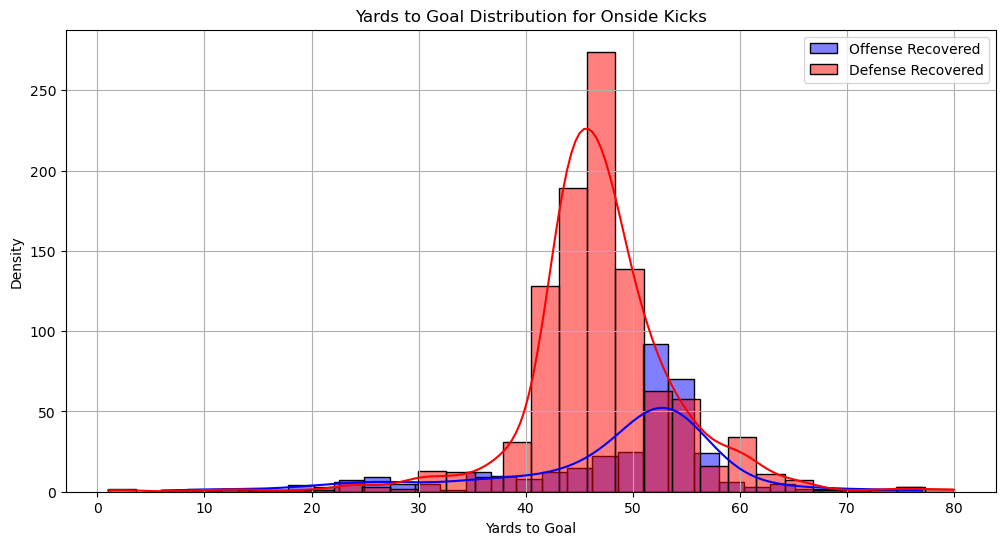

In [95]:
plt.figure(figsize=(12, 6))
sns.histplot(
    onside_kicks_mini.query('recovered_by == "offense"')['yards_to_goal'], 
    bins=30, 
    kde=True, 
    color='blue', 
    label='Offense Recovered'
)
sns.histplot(
    onside_kicks_mini.query('recovered_by == "defense"')['yards_to_goal'], 
    bins=30, 
    kde=True, 
    color='red', 
    label='Defense Recovered'
)
plt.title('Yards to Goal Distribution for Onside Kicks')
plt.xlabel('Yards to Goal')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

In [96]:
offense_yards = onside_kicks_mini.query('recovered_by == "offense"')['yards_to_goal'].values
defense_yards = onside_kicks_mini.query('recovered_by == "defense"')['yards_to_goal'].values

offense_kde = gaussian_kde(offense_yards, bw_method='scott')
defense_kde = gaussian_kde(defense_yards, bw_method='scott')

yardlines = np.arange(0, 100)
offense_pdf = offense_kde(yardlines)
defense_pdf = defense_kde(yardlines)

offense_pdf = offense_pdf / offense_pdf.sum()
defense_pdf = defense_pdf / defense_pdf.sum()

offense_df = pd.DataFrame({
    'yardline': yardlines,
    'probability': offense_pdf
})

defense_df = pd.DataFrame({
    'yardline': yardlines,
    'probability': defense_pdf
})

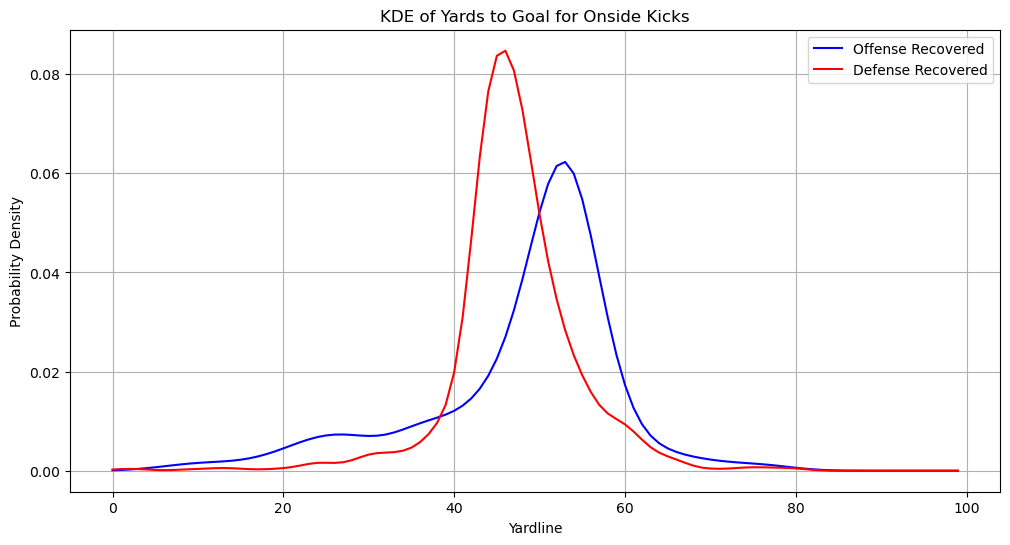

In [97]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='yardline', 
    y='probability', 
    data=offense_df, 
    label='Offense Recovered', 
    color='blue'
)
sns.lineplot(
    x='yardline', 
    y='probability', 
    data=defense_df, 
    label='Defense Recovered', 
    color='red'
)
plt.title('KDE of Yards to Goal for Onside Kicks')
plt.xlabel('Yardline')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

In [98]:
def estimate_onside_kick_time(yards_to_goal: float, recovered_by: str) -> float:
    """
    Estimate time used on an onside kick based on recovery team and yards to goal.
    
    Args:
        yards_to_goal (float): The ending field position after the onside kick.
        recovered_by (str): 'offense' or 'defense'
        
    Returns:
        float: Estimated seconds used (bounded between 1 and 4).
    """
    
    if recovered_by == 'offense':
        median = 52
        std_dev = 7
    elif recovered_by == 'defense':
        median = 47
        std_dev = 7
    else:
        raise ValueError("recovered_by must be 'offense' or 'defense'")
    
    # Compute how many std deviations from the median
    z = (yards_to_goal - median) / std_dev
    
    # Set 2 seconds at median, +/- 1 second per stdev from median
    time_estimate = 2.0 + np.abs(z)  # adjust this slope if too sensitive

    # Clamp to a realistic range
    return round(time_estimate, 2)

offense_df['seconds_used'] = offense_df['yardline'].apply(
    lambda x: estimate_onside_kick_time(x, 'offense')
)
defense_df['seconds_used'] = defense_df['yardline'].apply(
    lambda x: estimate_onside_kick_time(x, 'defense')
)

In [99]:
offense_df

,yardline,probability,seconds_used
0,0,9.293771e-05,9.43
1,1,1.566732e-04,9.29
2,2,2.479043e-04,9.14
3,3,3.695918e-04,9.00
4,4,5.212228e-04,8.86
5,5,6.980115e-04,8.71
6,6,8.908788e-04,8.57
7,7,1.087413e-03,8.43
8,8,1.273961e-03,8.29
9,9,1.438773e-03,8.14


In [100]:
model_dir = join('../models/raw', 'kickoffs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

offense_df[['probability','seconds_used']].to_parquet(
    os.path.join(model_dir, 'onside_kick_offense_yardline_distribution.parquet'),
    index=False
)
defense_df[['probability','seconds_used']].to_parquet(
    os.path.join(model_dir, 'onside_kick_defense_yardline_distribution.parquet'),
    index=False
)

### Issues with the data
There are spans of missing or mislabeled play data in some games. E.g. below, there is an onside kick by Tulane with 1:19 on the clock in Q4. The onside kick is recovered by South Alabama, but then South Alabama starts the drive with 84 YTG (verse from the Tulane 44 as in the play text), and the clock jumps up to 9:46 in Q4.

I chose to filter this instances out from the onside kick start yardline data.

In [541]:
plays.query('game_id==@gid and drive_number.isin([@drive_number - 1]) and play_number==22').play_text.values[0]

'Cairo Santos on-side kick recovered by SOUTH ALABAMA at the Tulan 44.'

In [536]:
plays.query('game_id==@gid and drive_number.isin([@drive_number, @drive_number - 1])').sort_values(
    by=['drive_number', 'play_number']
)[['offense','defense','drive_number','play_number','yards_to_goal','play_text','period','clock_minutes','clock_seconds']]

,offense,defense,drive_number,play_number,yards_to_goal,play_text,period,clock_minutes,clock_seconds
20596,Tulane,South Alabama,31,1,82,Nick Montana middle pass complete to Matt Marf...,4,6,2
20594,Tulane,South Alabama,31,2,64,Nick Montana deep pass incomplete to Ryan Grant.,4,6,2
20600,Tulane,South Alabama,31,3,64,Nick Montana sideline pass complete to Ryan Gr...,4,6,2
20587,Tulane,South Alabama,31,4,55,Orleans Darkwa rush up the middle for 2 yards ...,4,6,2
20595,Tulane,South Alabama,31,5,53,Nick Montana sideline pass incomplete to Justy...,4,6,2
20601,Tulane,South Alabama,31,6,53,Nick Montana middle pass complete to Xavier Ru...,4,6,2
20606,Tulane,South Alabama,31,7,43,Nick Montana rush quarterback draw for 11 yard...,4,6,2
20593,Tulane,South Alabama,31,8,32,Nick Montana screen pass complete to Rob Kelle...,4,6,2
20592,Tulane,South Alabama,31,9,26,Nick Montana slant pass complete to Sydie Lond...,4,6,2
20608,Tulane,South Alabama,31,10,23,Josh Rounds rush up the middle for 1 yard to t...,4,6,2
